In [85]:
import matplotlib.pyplot as plt
import numpy as np
import debugpy
import glob
import pandas as pd
import seaborn as sns
import scipy.stats as stats

# Exploratory data analysis of cell props dataset
#  subject: Extracted features from image segmentation masks of cells using transfer learning + Cellpose 2.0
#  goal: understand class sizes, distributions of features, collinearity, missing data
#  test: effectiveness of regression as a first approach with high interpretability
#

cellprops = pd.read_csv("data/cellprops_coronal.csv")
print(cellprops.columns)
print(f"\nNumber of cells = {np.shape(cellprops)[0]}")
# because 'image' column is a string datatype, map it to unique values 'image_id' for visualization
cellprops['image_id'] = cellprops['image'].rank(method='dense', ascending=False).astype(int)
cellprops['embryo_id'] = cellprops['embryo'].rank(method='dense', ascending=False).astype(int)
cellprops = cellprops.drop(labels=['image', 'embryo'], axis=1)
classes = cellprops['genotype'].unique()
print(cellprops.columns)

Index(['Area', 'Centroid_1', 'Centroid_2', 'Eccentricity', 'Orientation',
       'Circularity', 'EulerNumber', 'Perimeter', 'MeanIntensity', 'roi_id',
       'image', 'embryo', 'genotype', 'zslice', 'Edgecell', 'EdgeCentroid_1',
       'EdgeCentroid_2'],
      dtype='object')

Number of cells = 143096
Index(['Area', 'Centroid_1', 'Centroid_2', 'Eccentricity', 'Orientation',
       'Circularity', 'EulerNumber', 'Perimeter', 'MeanIntensity', 'roi_id',
       'genotype', 'zslice', 'Edgecell', 'EdgeCentroid_1', 'EdgeCentroid_2',
       'image_id', 'embryo_id'],
      dtype='object')


Area
Centroid_1
Centroid_2
Eccentricity
Orientation
Circularity
EulerNumber
Perimeter
MeanIntensity
roi_id
genotype
zslice
Edgecell
EdgeCentroid_1
EdgeCentroid_2
image_id
embryo_id


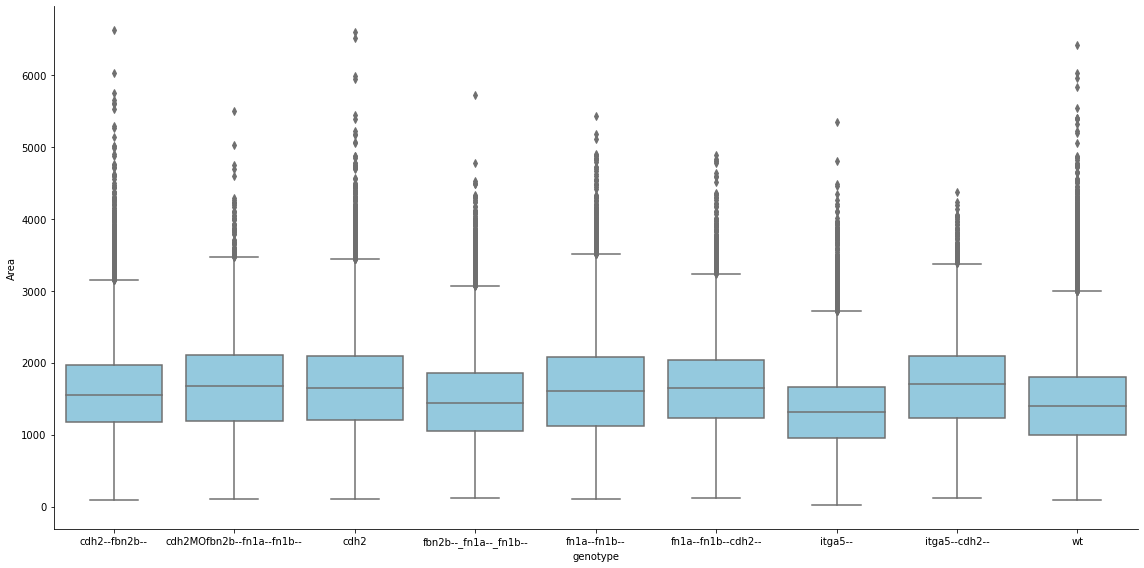

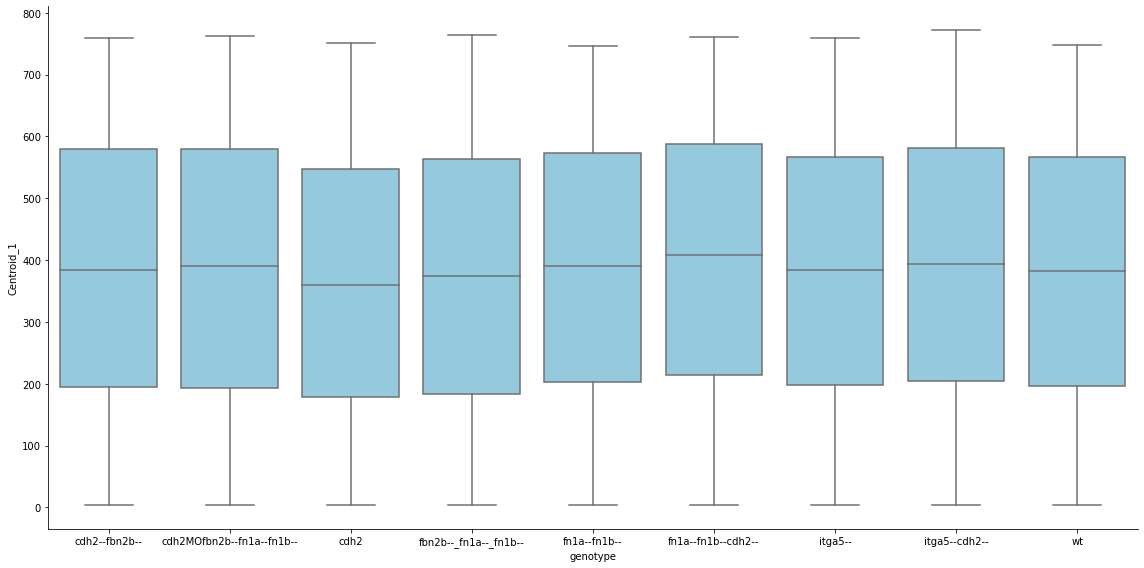

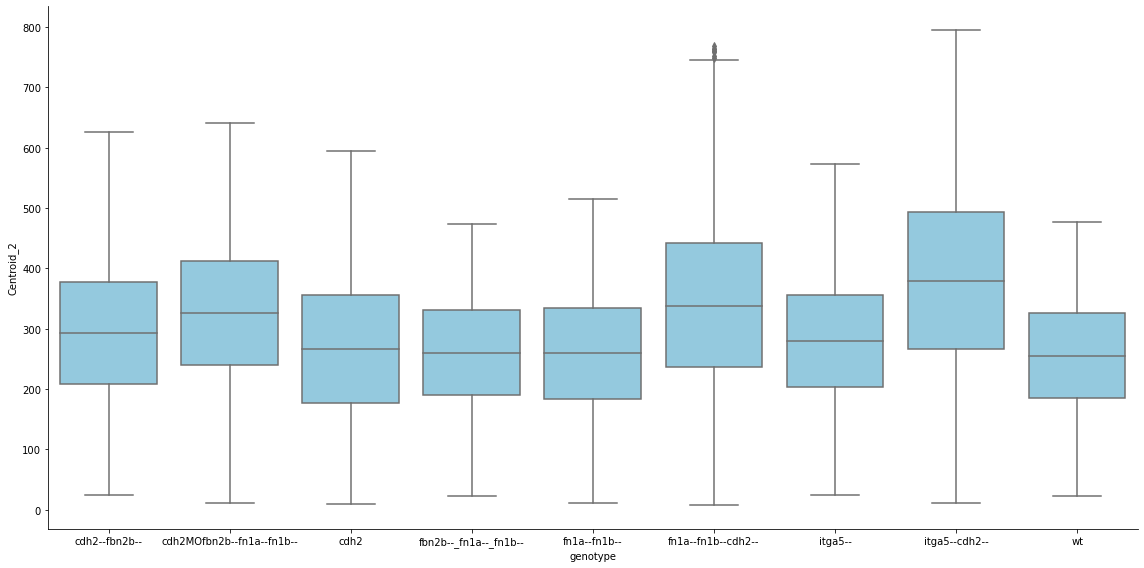

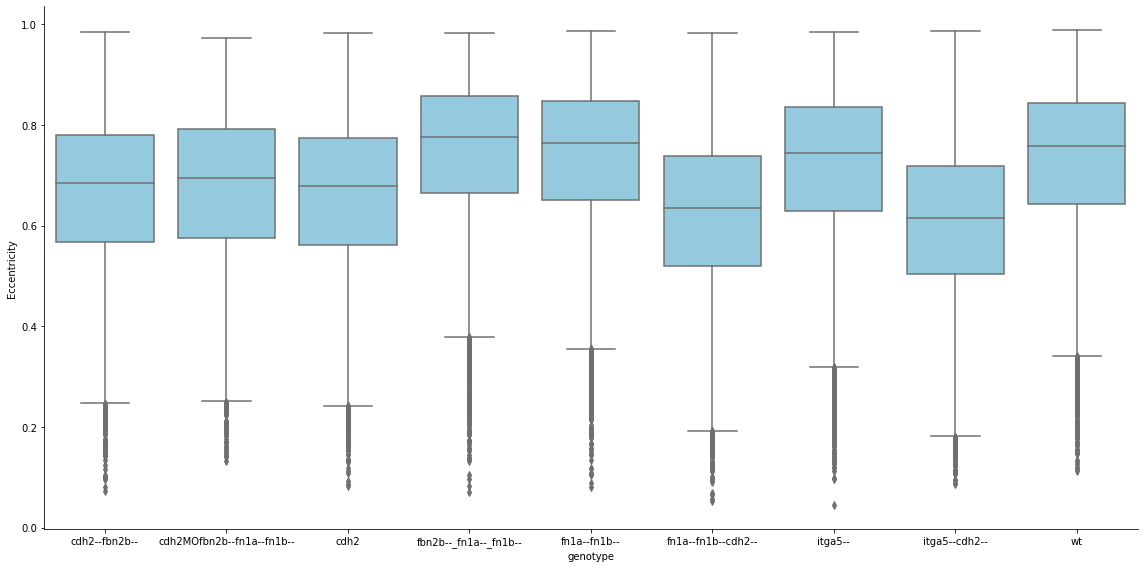

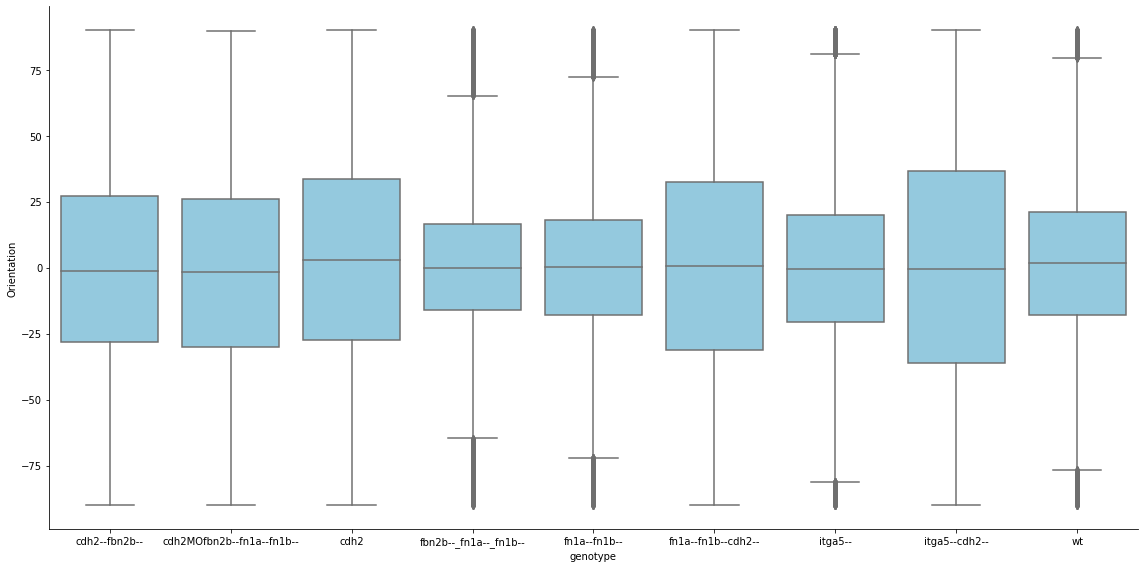

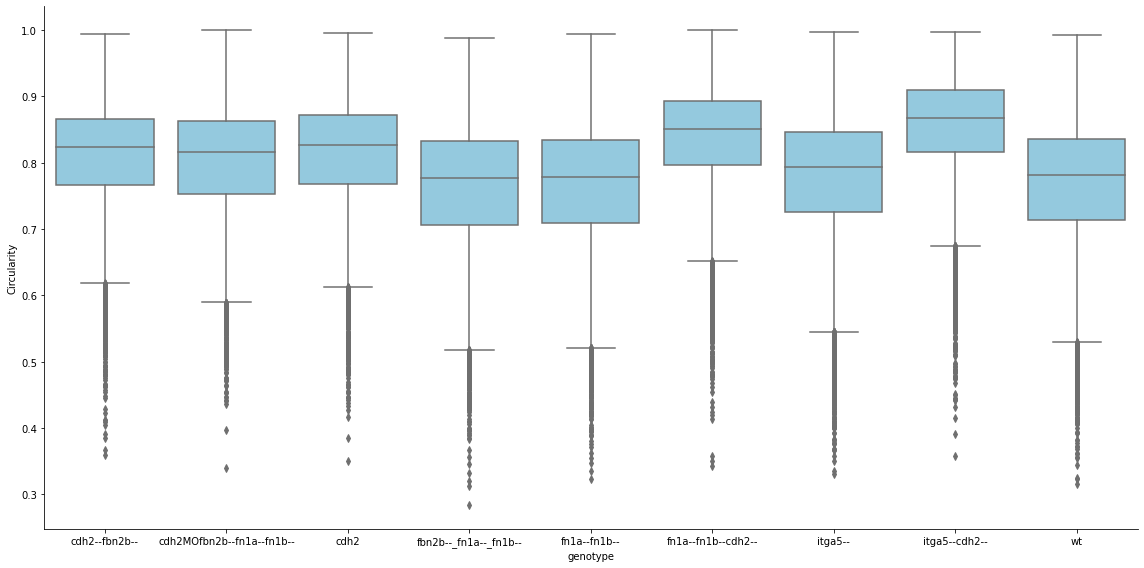

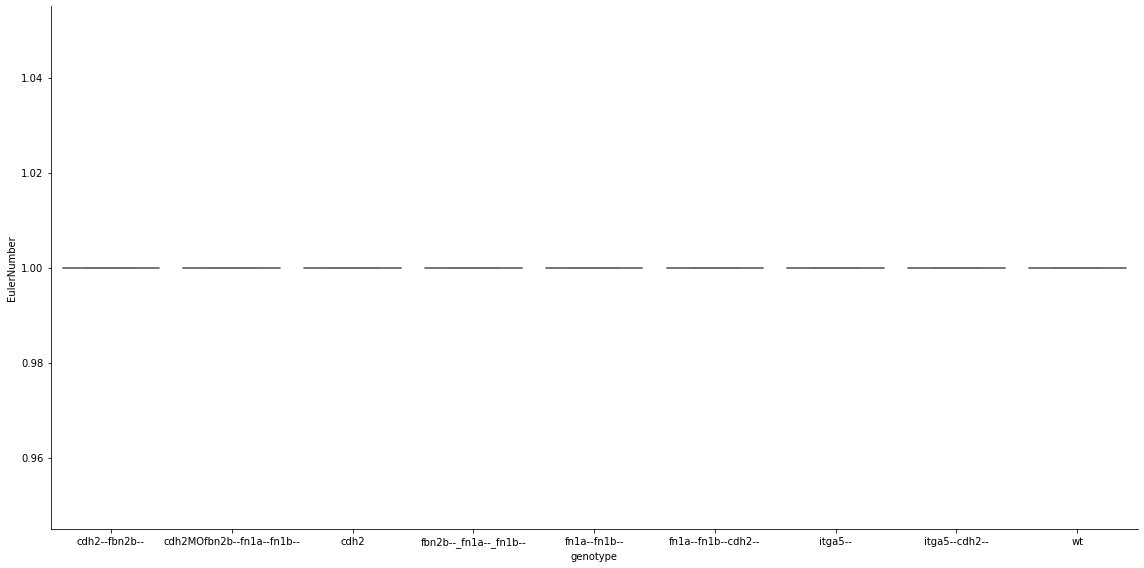

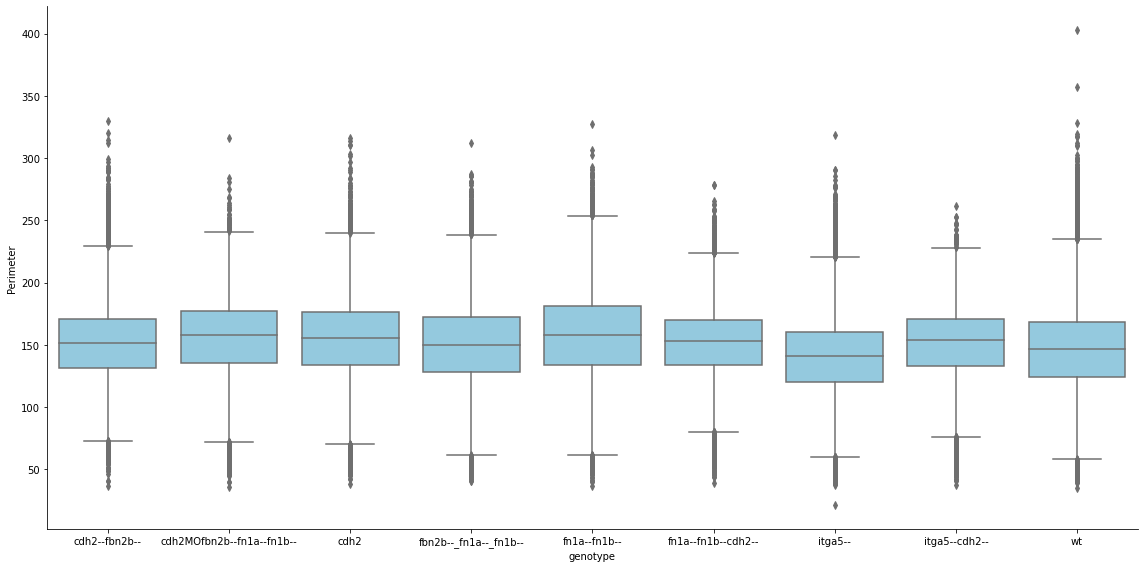

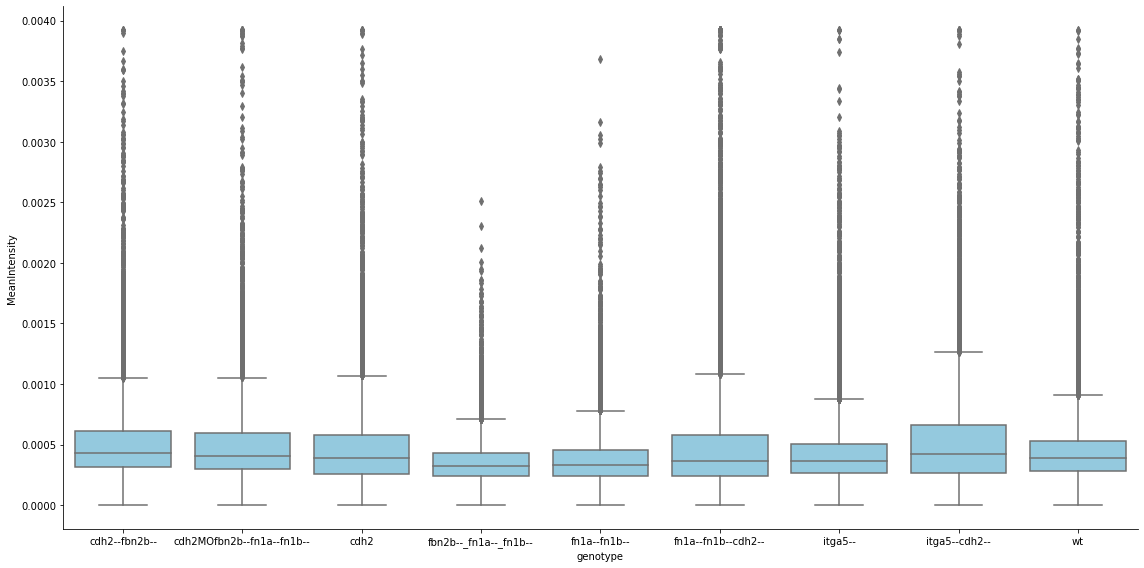

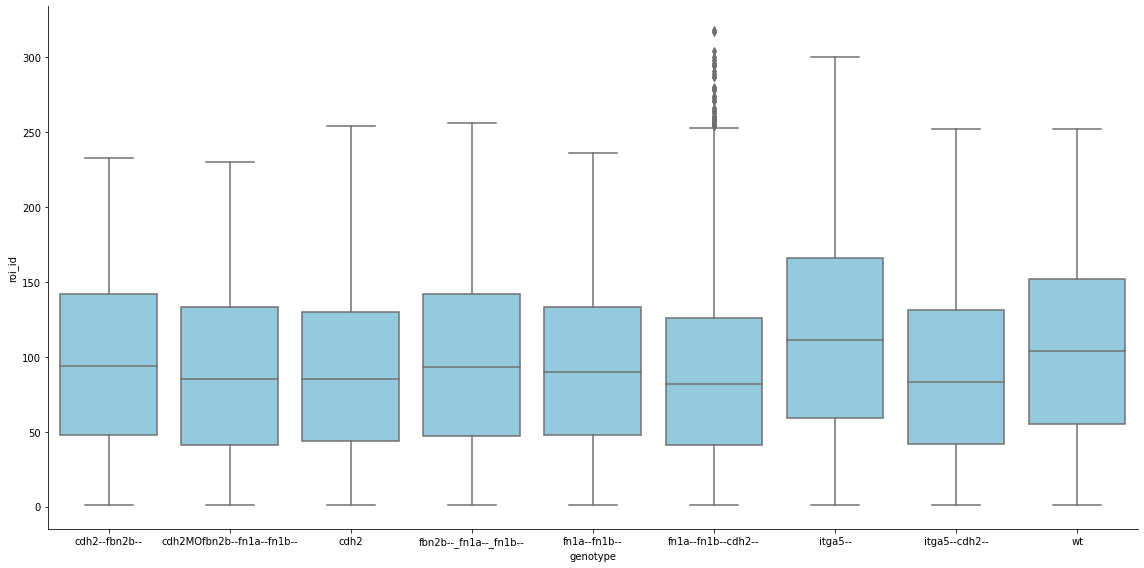

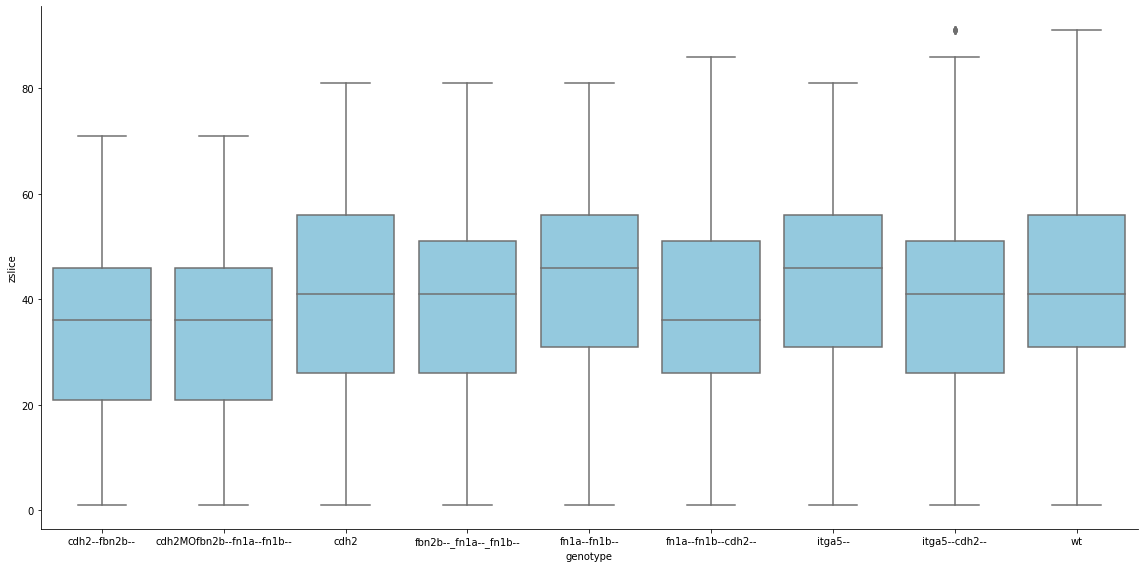

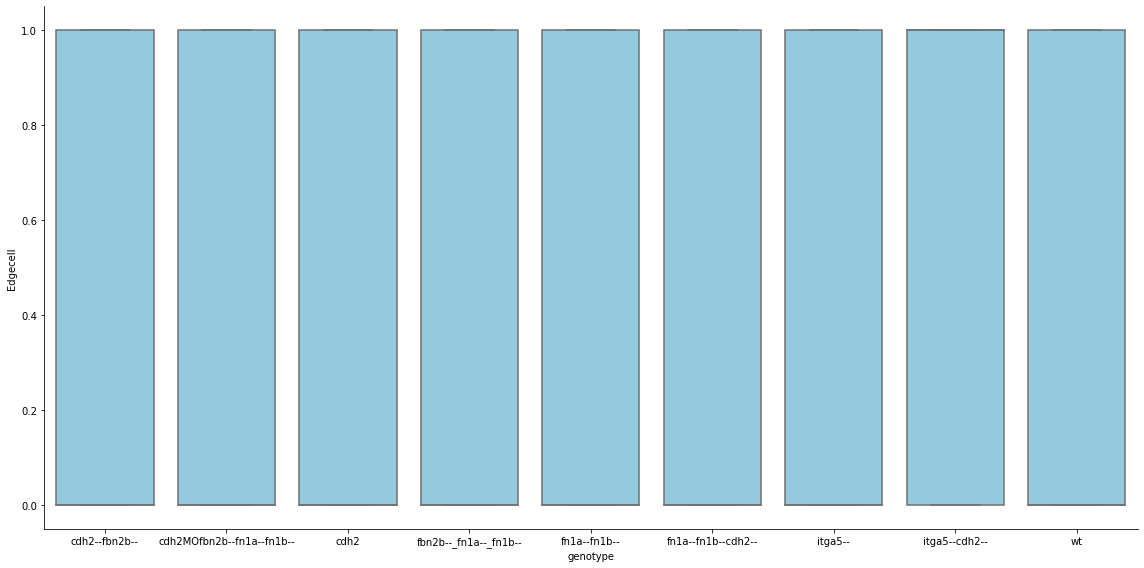

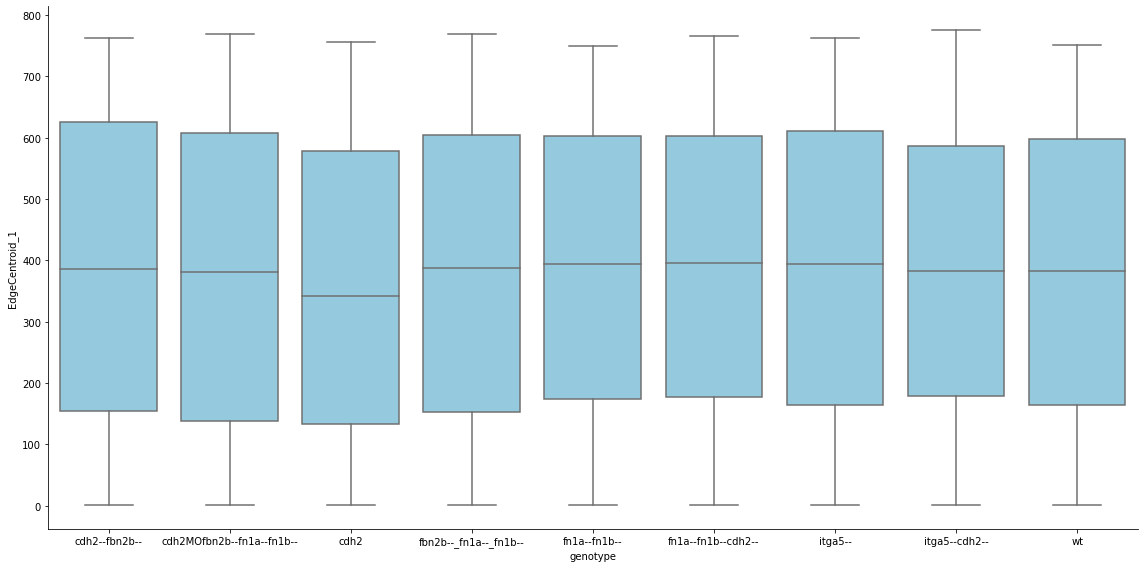

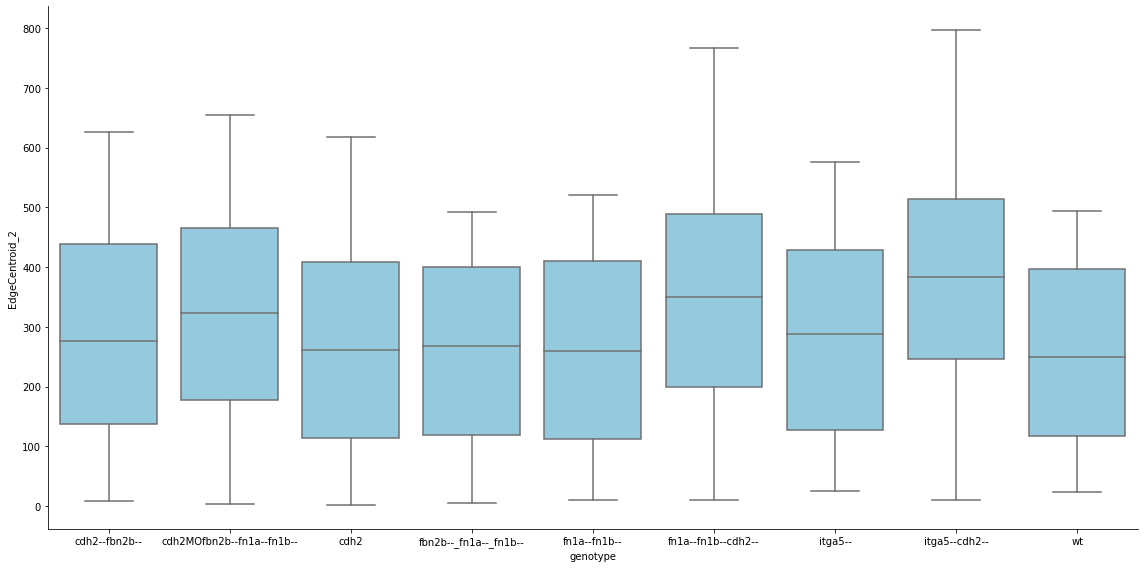

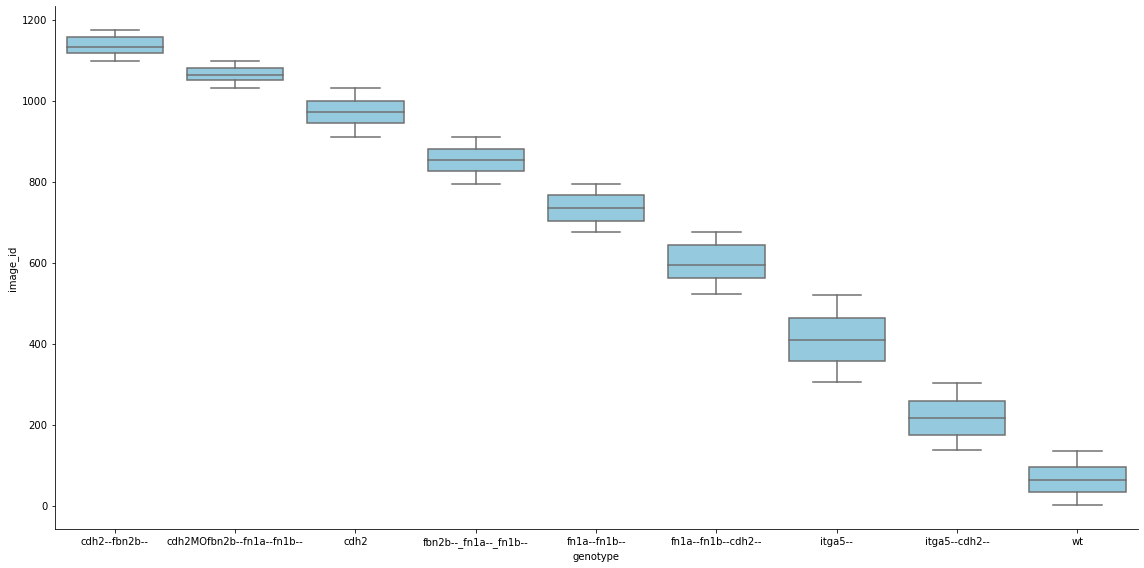

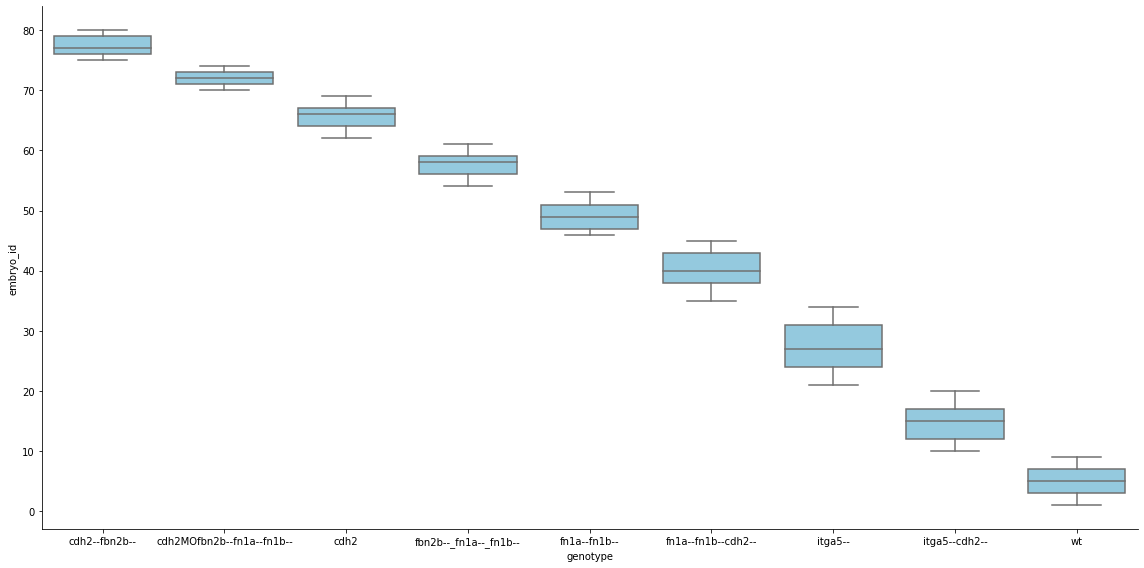

In [69]:
'''Description of the dataset includes all feature names, 
their statistical properties as a whole, and their statistical properties 
when grouped by their classes
'''

for col in cellprops.columns:
    print(col)
    if col != 'genotype':
        #print(cellprops.groupby('genotype')[col].describe())
        sns.catplot(data=cellprops, x='genotype', y=col, kind='box', color='skyblue', height=8, aspect=2)


Area
Centroid_1
Centroid_2
Eccentricity
Orientation
Circularity
Perimeter
MeanIntensity
genotype
zslice


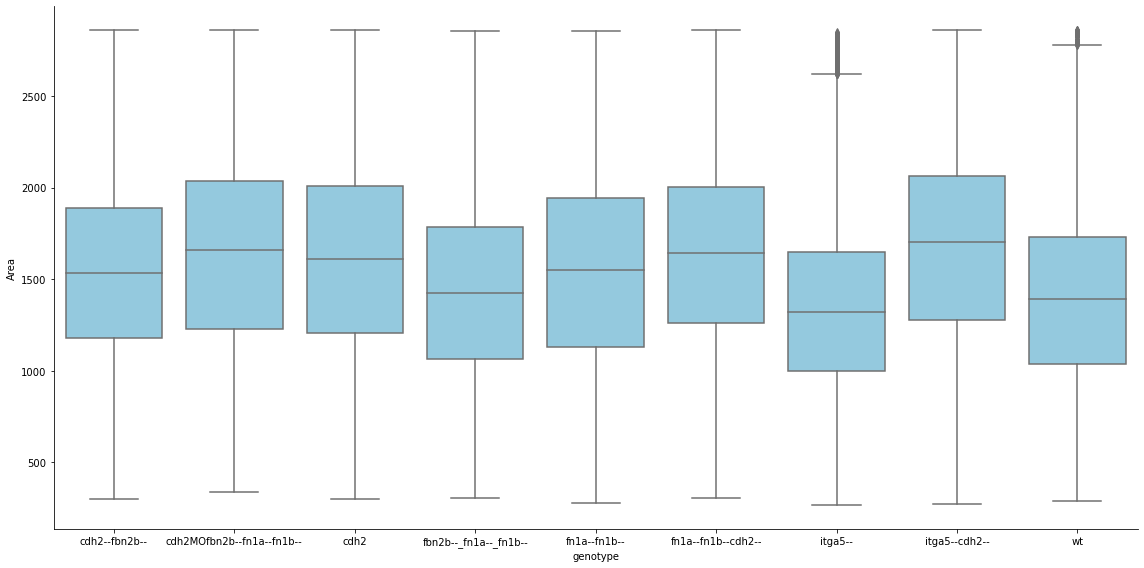

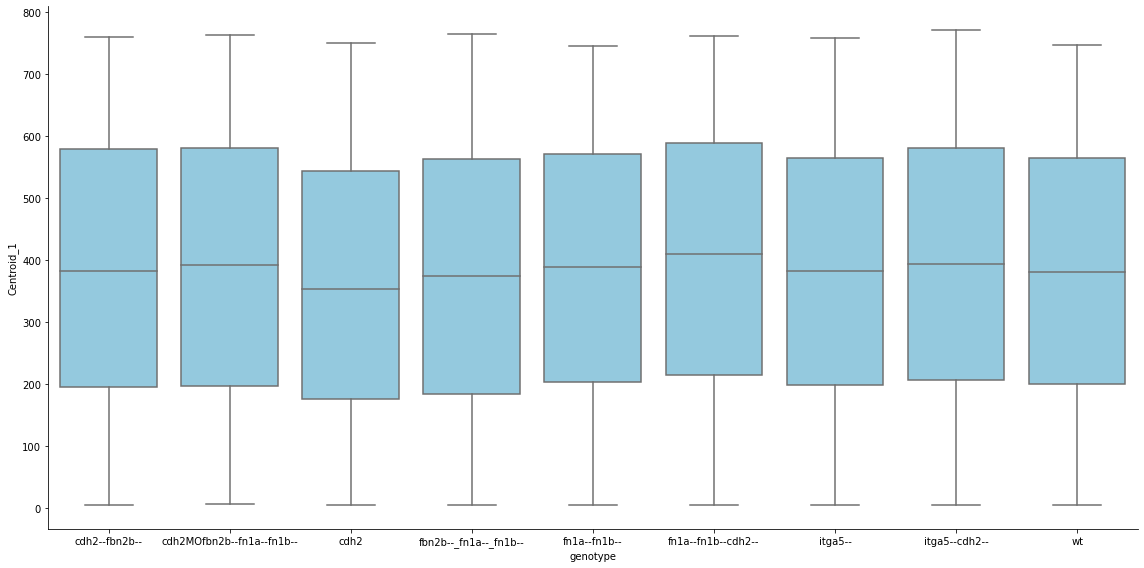

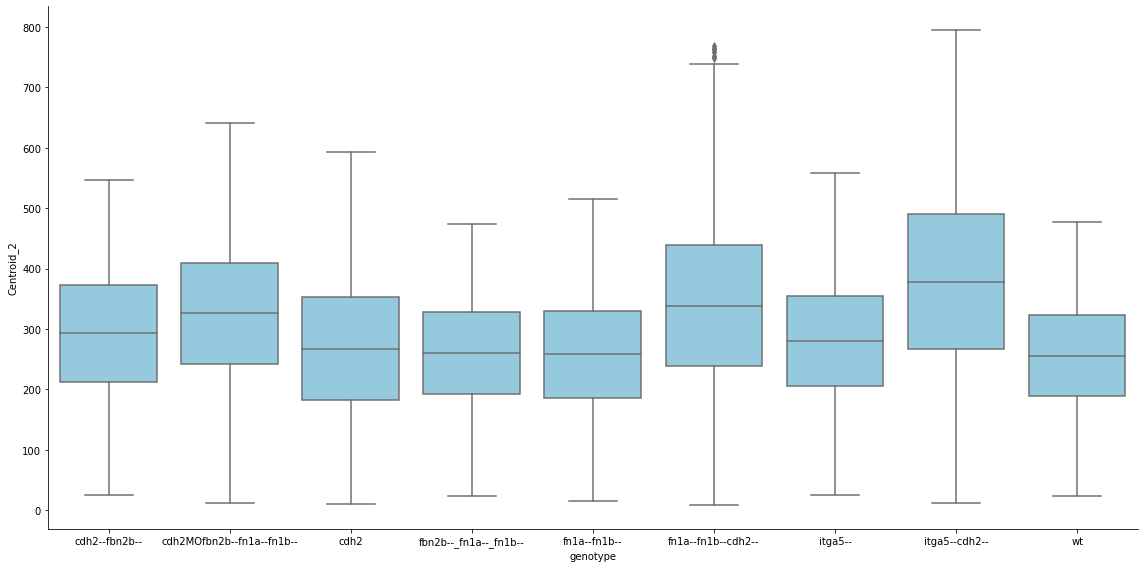

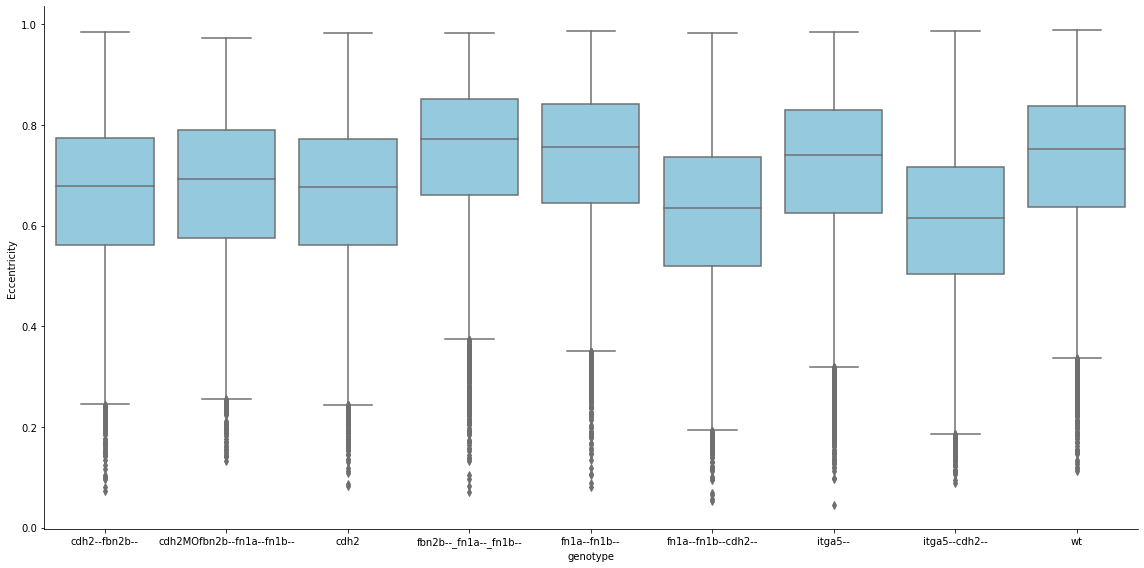

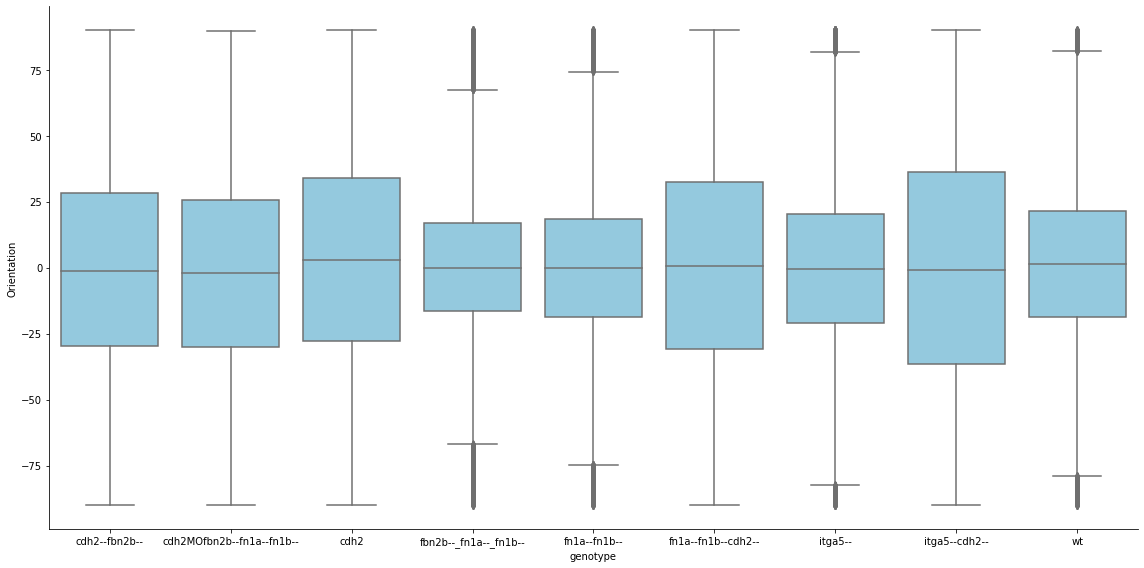

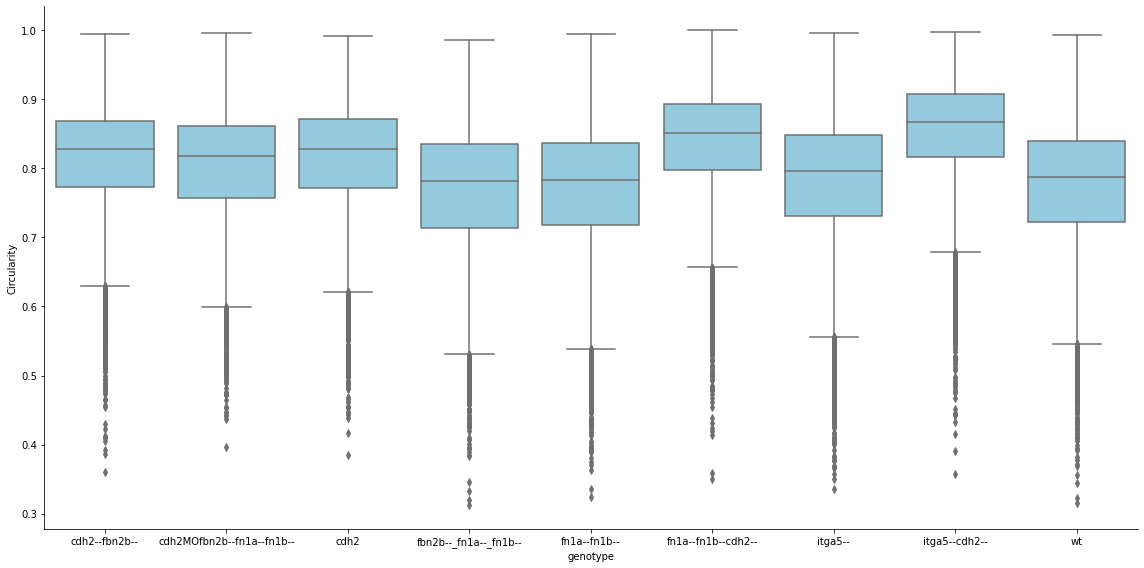

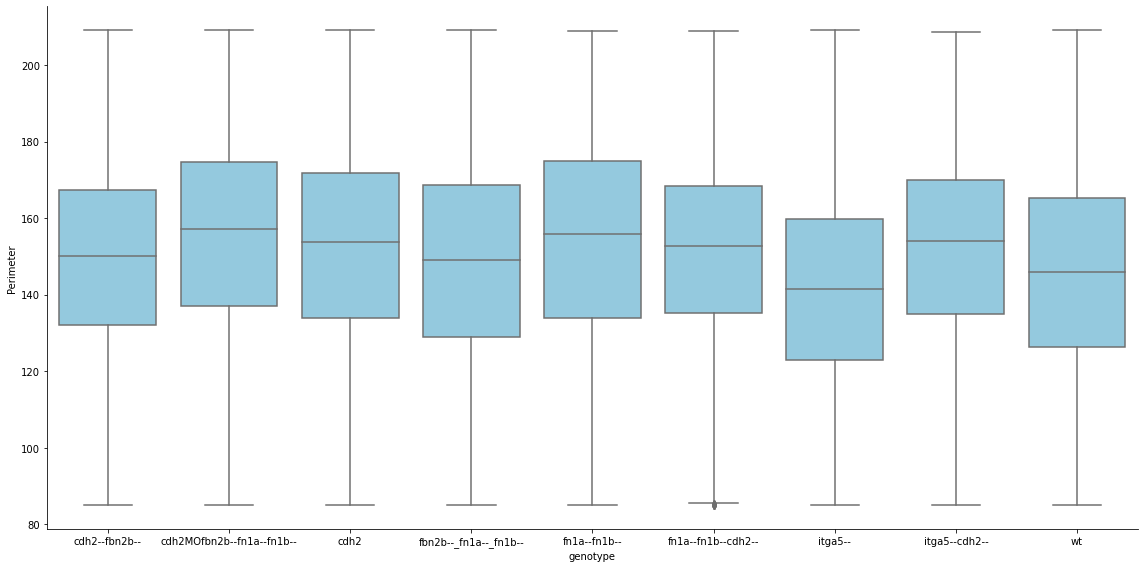

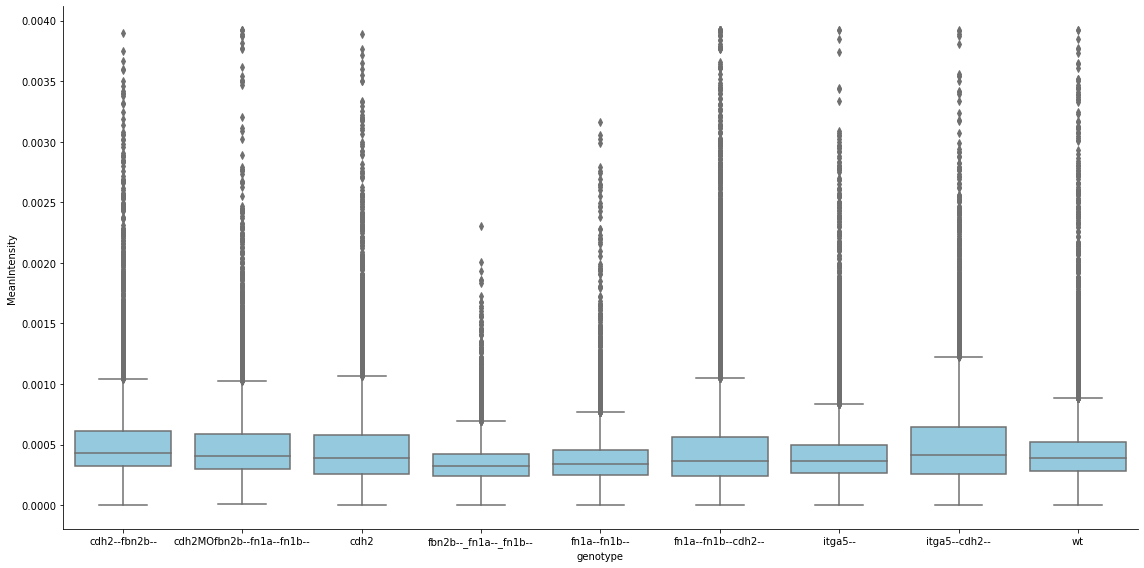

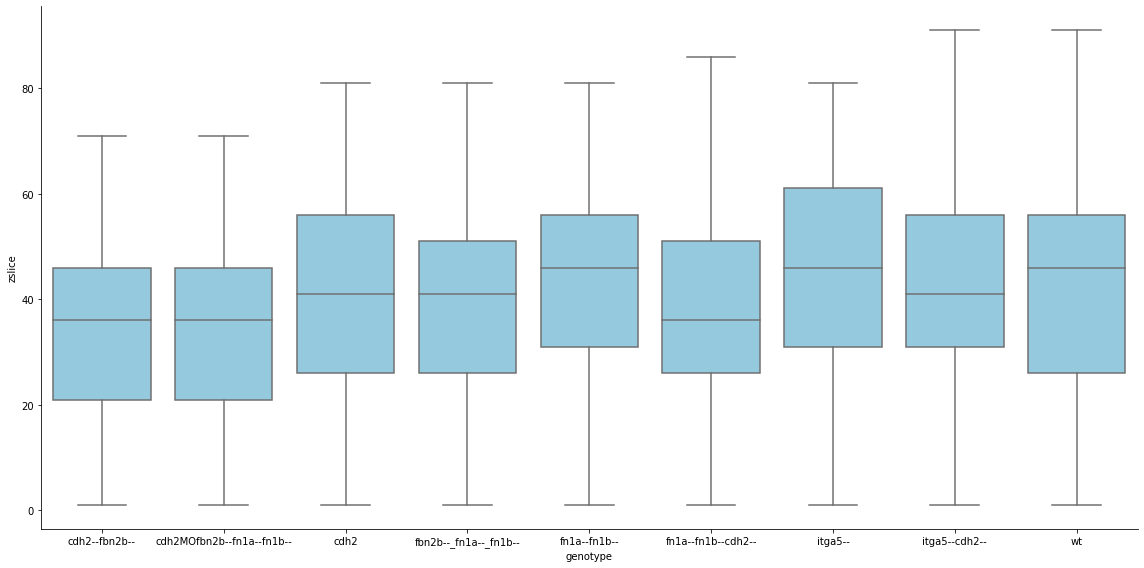

In [86]:
# Euler number represents the topology of a cell, i.e. number of holes. 
# This has no variation due to the cell segmentation model not producing 
# cells with holes, so we eliminate this feature.
cellprops = cellprops.drop(['EulerNumber', 'roi_id', 'embryo_id', 'image_id', 'Edgecell', 'EdgeCentroid_1', 'EdgeCentroid_2'], axis=1)
# drop rows with outliers in area and perimeter
cellprops = cellprops[(np.abs(stats.zscore(cellprops['Area'])) < 2)]
cellprops = cellprops[(np.abs(stats.zscore(cellprops['Perimeter'])) < 2)]
for col in cellprops.columns:
    print(col)
    if col != 'genotype':
        #print(cellprops.groupby('genotype')[col].describe())
        sns.catplot(data=cellprops, x='genotype', y=col, kind='box', color='skyblue', height=8, aspect=2)

In [90]:
X = cellprops.drop('genotype', axis=1)
Y = cellprops['genotype']
print(cellprops.groupby('genotype').describe())
print(X.corr())

                              Area                                           \
                             count         mean         std    min      25%   
genotype                                                                      
cdh2                       12976.0  1610.635173  547.788936  298.0  1209.00   
cdh2--fbn2b--               9520.0  1540.046744  511.097813  298.0  1179.75   
cdh2MOfbn2b--fn1a--fn1b--   6999.0  1634.103300  555.934789  341.0  1228.00   
fbn2b--_fn1a--_fn1b--      13254.0  1441.247397  504.798338  307.0  1063.25   
fn1a--fn1b--               12059.0  1549.448462  546.379942  280.0  1132.00   
fn1a--fn1b--cdh2--         15057.0  1627.757189  526.843195  307.0  1261.00   
itga5--                    30624.0  1340.639433  464.593565  267.0   998.00   
itga5--cdh2--              14337.0  1666.948734  546.359640  272.0  1277.00   
wt                         16073.0  1401.588005  497.678120  287.0  1035.00   

                                                   

In [91]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1121218
)

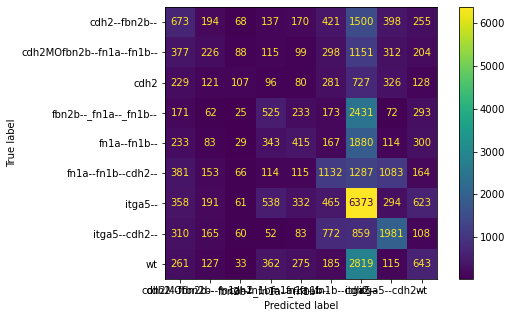

In [93]:
# Fit/predict
etc = ExtraTreesClassifier()
_ = etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 16))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=classes,
)

cmp.plot(ax=ax)


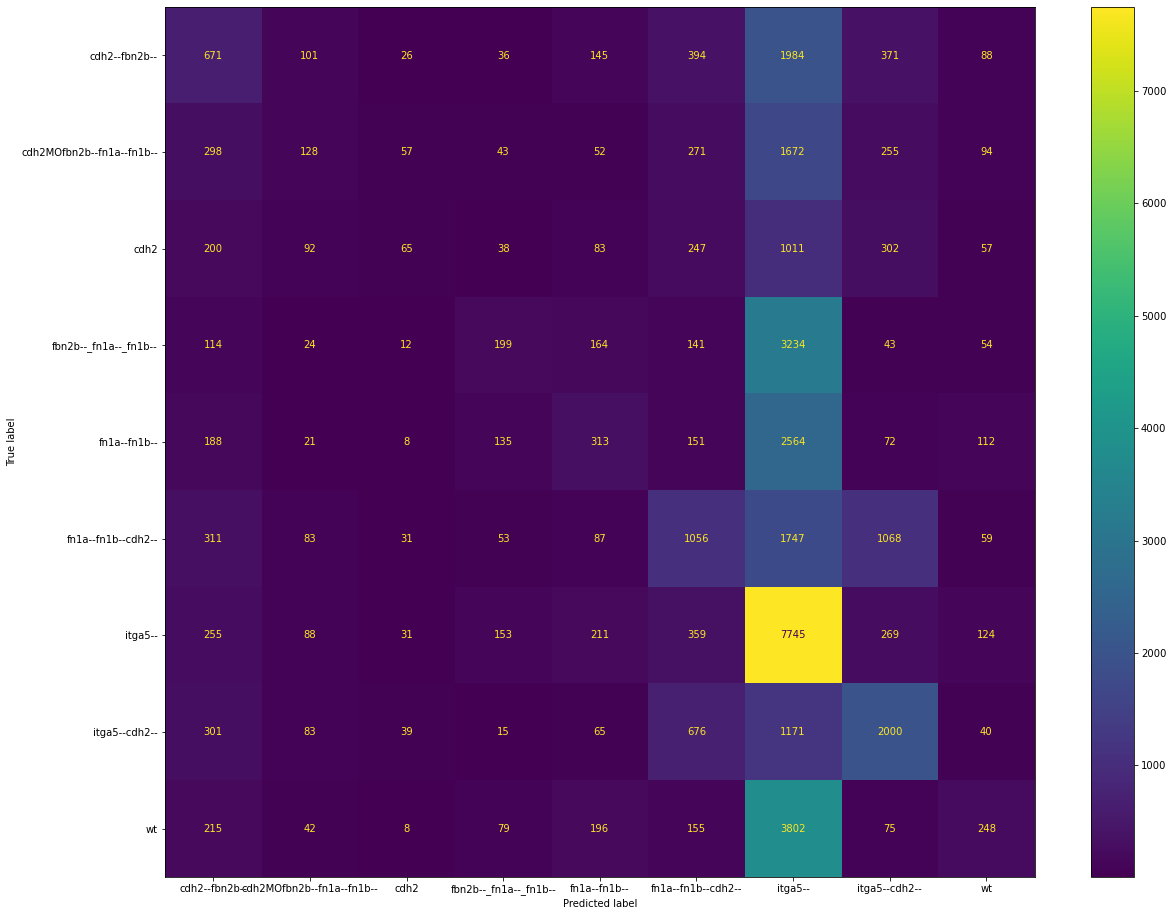

In [99]:
from sklearn.linear_model import Perceptron,  SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

# Init/fit
ovr = OneVsRestClassifier(estimator=GradientBoostingClassifier())
_ = ovr.fit(X_train, y_train)

y_pred = ovr.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 16))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=classes,
)

cmp.plot(ax=ax)